In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
import tensorflow_probability as tfp
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import tensorflow as tf
from scipy import stats
tfd=tfp.distributions
from tqdm import notebook
from scipy import optimize
from functools import partial
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

### Load Data

In [3]:
train=np.load('Train.npy')
test=np.load('Test.npy')

train_x=train[:,:-1]
train_y=train[:,-1].reshape(-1,1)

test_x=test[:,:-1]
test_y=test[:,-1].reshape(-1,1)

ntrain=len(train_x)
ntest=len(test_x)


#### normalization function

In [4]:
##define a normalization function
def norm_data(train, test,norm=True):
    std_train=np.ones(train.shape[1])
    mu_train=np.zeros(train.shape[1])
    if(norm):
        std_train = np.std(train, 0)
        mu_train=np.mean(train,0)

    train=(train - np.full(train.shape, mu_train)) / \
            np.full(train.shape, std_train)
    test=(test - np.full(test.shape, mu_train)) / \
            np.full(test.shape, std_train)
    return train,test,mu_train,std_train

In [ ]:
#train_x,test_x,_,_=norm_data(train_x,test_x,norm=False)
#train_y,_,muy,stdy=norm_data(train_y,test_y,norm=False)

### Ensemble method based of hetero regression(EN)

In [5]:
class EN:
    def __init__(self,lr,tau):
        self.lr=lr
        self.tau=tau
    
    def model_musd(self,trainx,trainy,testx):
        #the model
        model=tf.keras.Sequential([
            tf.keras.layers.Dense(100,activation=tf.nn.elu),
            tf.keras.layers.BatchNormalization(axis=-1),
            tf.keras.layers.Dense(50,activation=tf.nn.elu),
            tf.keras.layers.BatchNormalization(axis=-1),
            tf.keras.layers.Dense(1+1),
            tfp.layers.DistributionLambda(
            lambda t:tfd.Normal(loc=t[...,:1],
            scale=tf.math.softplus(self.tau*t[...,1:])+0.001)),
        ])

        #the loss
        negloglik = lambda y, p_y: -p_y.log_prob(y)

        #the model fitting for 5 models
        mut=np.empty(len(testx))
        sdt=np.empty(len(testx))
        for i in notebook.tnrange(5):
            model.compile(optimizer=tf.optimizers.Adam(self.lr),loss=negloglik)
            model.fit(trainx,trainy,epochs=500,batch_size=128,verbose=0)
            yhatt=model(testx)
            mu1=np.array(yhatt.mean()).ravel()
            sd1=np.array(yhatt.stddev()).ravel()
            mut=np.c_[mut,mu1]
            sdt=np.c_[sdt,sd1]

        sdt=sdt[:,1:]
        mut=mut[:,1:]


        #the averaged mean and sd for the ensemble model
        muhat=np.mean(mut,1)
        sighat=np.sqrt(np.mean(sdt**2+mut**2,1)-muhat**2)
        return muhat, sighat


#### 5-fold cross validation for parameter tuning

In [6]:
lrval=[1.e-4,5.e-4,1.e-3]
tauval=[0.01,0.05,0.1]
hyperparam=np.zeros((9,2))
hyperparam[:,0]=np.repeat(lrval,3)
hyperparam[:,1]=np.tile(tauval,3)

In [7]:
## create 5 folds
id = np.arange(len(train_x))
kf = KFold(n_splits=5)
tuneresult=[]


for i in range(len(hyperparam)):
    
    ## tuning parameter
    lrtmp=hyperparam[i,0]
    tautmp=hyperparam[i,1]

    for trainid, testid in kf.split(id):
        entmp=EN(lrtmp,tautmp)
        mutmp,stdtmp=entmp.model_musd(train_x[trainid],train_y[trainid],train_x[testid])

        ## extract validation y
        testytmp=train_y[testid]
 
        ##likelihood
        low=np.quantile(testytmp,0.05)
        high=np.quantile(testytmp,0.95)
        itv=np.linspace(low,high,9)
        itv=np.append(-np.infty,itv)
        itv=np.append(itv,np.infty)
        #outcome1 belongs to which interval
        ids=np.zeros(len(testytmp))
        for i in range(10):
            ids=ids+1*(testytmp.ravel()>itv[i+1])
        ids=ids.astype('int')
        
        l=(itv[ids]-mutmp)/stdtmp
        r=(itv[ids+1]-mutmp)/stdtmp
        prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
        ll_est=np.log(prtmp+1.e-10)
        
        tuneresult.append(ll_est.mean())            



In [8]:
list(zip([np.mean(tuneresult[i*5:(i+1)*5]) for i in range(9)],hyperparam))

[(-1.855854649022051, array([0.0001, 0.01  ])),
 (-1.7407093298157832, array([0.0001, 0.05  ])),
 (-1.7281154216940293, array([0.0001, 0.1   ])),
 (-1.6935248562361742, array([0.0005, 0.01  ])),
 (-1.482951752325652, array([0.0005, 0.05  ])),
 (-1.3412003249754854, array([0.0005, 0.1   ])),
 (-1.6130494231683954, array([0.001, 0.01 ])),
 (-1.3989455111311582, array([0.001, 0.05 ])),
 (-1.1800396296434665, array([0.001, 0.1  ]))]

### We choose lr=1e-3,tau=0.1 ad the best tunning parameter for model fitting

In [32]:
ENmodel=EN(1.e-3,0.1)
mutmp,stdtmp=ENmodel.model_musd(train_x,train_y,np.r_[train_x,test_x])

In [33]:
enmu,enstd=mutmp[ntrain:],stdtmp[ntrain:]

### Evaluation

#### median by mae

In [39]:
np.abs(enmu-test_y.ravel()).mean()

0.1575625811814709

#### Calibration

In [35]:
per=np.linspace(0.02,0.98,8)


In [36]:
#generate confidence interval estimated mean and std
enc=[]
enwidth=stats.norm.ppf(0.95)*2*enstd

per=np.linspace(0.02,0.98,8)
for i in per:
    lquantile=(stats.norm.ppf(0.5-i/2.)*enstd+enmu)
    rquantile=(stats.norm.ppf(0.5+i/2.)*enstd+enmu)
    enc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

l90=(stats.norm.ppf(0.5-0.9/2.)*enstd+enmu)
r90=(stats.norm.ppf(0.5+0.9/2.)*enstd+enmu)
np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel()))    

0.8809523809523809

In [51]:
np.array(enc),np.abs(enc-per).mean()

(array([0.02380952, 0.19047619, 0.36904762, 0.45238095, 0.57142857,
        0.67857143, 0.85714286, 0.95238095]), 0.02559523809523806)

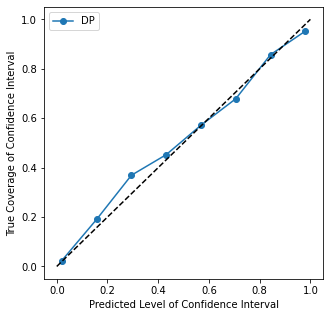

In [38]:
plt.plot(per,enc,'o-',label='DP')
plt.xlabel('Predicted Level of Confidence Interval')
plt.ylabel('True Coverage of Confidence Interval')
plt.legend()
plt.plot([0,1],[0,1],'k--')
fig = plt.gcf()
fig.set_size_inches(5,5)

#### log likelihood


In [40]:
##likelihood
low=np.quantile(test_y,0.05)
high=np.quantile(test_y,0.95)
itv=np.linspace(low,high,9)
itv=np.append(-np.infty,itv)
itv=np.append(itv,np.infty)
#outcome1 belongs to which interval
id=np.zeros(len(test_y))
for i in range(10):
    id=id+1*(test_y.ravel()>itv[i+1])
id=id.astype('int')

In [41]:
l=(itv[id]-enmu)/enstd
r=(itv[id+1]-enmu)/enstd
prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
ll_est=np.log(prtmp+1.e-10)
ll_est.mean()

-1.1811074198856253

### Sharpness

In [47]:
enwidth=np.median(enstd)*stats.norm.ppf(per/2+0.5)*2.
enwidth

array([0.00592224, 0.04683196, 0.08920794, 0.13469296, 0.1858605 ,
       0.24775896, 0.33421757, 0.54957292])

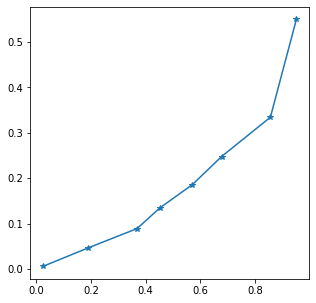

In [50]:
### sharpness plot
plt.figure(figsize=(5,5))
plt.plot(enc,enwidth,'-*')